In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, BertPreTrainedModel
from transformers.modeling_outputs import SequenceClassifierOutput
import sqlite3
import faiss 
import json
from tqdm.auto import tqdm
import time

# --- 1. GPUの確認 ---
if torch.cuda.is_available():
    print(f"✅ GPU is available. Device: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("⚠️ GPU not found. Running on CPU.")
    device = torch.device("cpu")

✅ GPU is available. Device: NVIDIA RTX A6000


In [2]:
# --- 2. カスタムモデルクラスの定義 ---
class SiameseContrastiveWithHeadModel(BertPreTrainedModel):
    def __init__(self, config):
        super(SiameseContrastiveWithHeadModel, self).__init__(config)
        self.bert = AutoModel.from_config(config)
        
        self.classifier_head = nn.Sequential(
            nn.Linear(config.hidden_size * 4, config.hidden_size),
            nn.ReLU(),
            nn.Linear(config.hidden_size, 1)
        )
        self.init_weights()

    def _get_vector(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return output.pooler_output

    def forward(self, input_ids=None, **kwargs):
        pass 

print("Custom model class 'SiameseContrastiveWithHeadModel' defined.")

Custom model class 'SiameseContrastiveWithHeadModel' defined.


In [3]:
# --- 3. 設定とリソースのロード ---
DB_PATH = "data/processed/s2orc_filtered.db"

# ▼▼▼ 訓練済みのContrastiveモデル ▼▼▼
TRAINED_MODEL_PATH = "models/sbert_contrastive_with_head_v1/best_model"

# ▼▼▼ Contrastiveモデルで作成したインデックス ▼▼▼
FAISS_INDEX_FILE = "data/processed/contrastive_scibert.faiss"
DOI_MAP_FILE = "data/processed/contrastive_doi_map.json"

# 評価データ
EVAL_PAPERS_FILE = "data/datapapers/sampled/evaluation_data_papers_50_v2.csv"
TRAIN_FILE = "data/processed/training_dataset_hard_negatives_1to3.csv"

# 出力ファイル
RICH_RESULTS_FILE = "data/processed/contrastive_evaluation_results.json"

# 評価するkの値
# ランキング上位の精度を見るための小さいk
small_k_values = [1, 5, 10, 30, 50, 100, 200, 300, 500]
# 網羅性を見るための大きいk (1000刻みで30000まで)
large_k_values = list(range(1000, 30001, 1000))

EVAL_K_VALUES = sorted(list(set(small_k_values + large_k_values)))

# SAVE_TOP_K も評価の最大値に合わせる
SAVE_TOP_K = 30000 

MAX_LENGTH = 512

print(f"Loading tokenizer & model from: {TRAINED_MODEL_PATH}")
tokenizer = AutoTokenizer.from_pretrained(TRAINED_MODEL_PATH)
model = SiameseContrastiveWithHeadModel.from_pretrained(TRAINED_MODEL_PATH).to(device)
model.eval()

print(f"Loading DOI map from {DOI_MAP_FILE}...")
with open(DOI_MAP_FILE, 'r') as f:
    doi_to_index = json.load(f)
id_to_doi = {v: k for k, v in doi_to_index.items()}

print(f"Loading Faiss index: {FAISS_INDEX_FILE}")
index = faiss.read_index(FAISS_INDEX_FILE)
total_vectors = index.ntotal
print(f"Faiss index loaded. Total vectors: {total_vectors:,}")

Loading tokenizer & model from: models/sbert_contrastive_with_head_v1/best_model
Loading DOI map from data/processed/contrastive_doi_map.json...
Loading Faiss index: data/processed/contrastive_scibert.faiss
Faiss index loaded. Total vectors: 11,619,136


In [4]:
# --- 4. 評価データ（クエリと正解）の準備 ---
print("Preparing evaluation queries and ground truth...")

df_train = pd.read_csv(TRAIN_FILE)
df_train = df_train.dropna(subset=['abstract_a', 'abstract_b'])
train_dois = set(df_train['abstract_a']) | set(df_train['abstract_b'])
print(f"Loaded {len(train_dois):,} training DOIs to exclude.")

df_eval_papers = pd.read_csv(EVAL_PAPERS_FILE)
eval_data_paper_dois = tuple(df_eval_papers['cited_datapaper_doi'].unique())

evaluation_queries = [] 
with sqlite3.connect(DB_PATH) as conn:
    for data_paper_doi in tqdm(eval_data_paper_dois, desc="Building Ground Truth"):
        query_gt = "SELECT citing_doi FROM positive_candidates WHERE cited_datapaper_doi = ? AND human_annotation_status = 1"
        gt_rows = conn.execute(query_gt, (data_paper_doi,)).fetchall()
        ground_truth_dois = {row[0] for row in gt_rows}
        
        if len(ground_truth_dois) >= 2:
            query_doi = ground_truth_dois.pop()
            query_text = conn.execute("SELECT abstract FROM papers WHERE doi = ?", (query_doi,)).fetchone()
            if query_text:
                evaluation_queries.append({
                    "query_doi": query_doi,
                    "query_abstract": query_text[0],
                    "ground_truth_dois": list(ground_truth_dois)
                })

print(f"Prepared {len(evaluation_queries)} valid evaluation queries.")

Preparing evaluation queries and ground truth...
Loaded 2,338 training DOIs to exclude.


Building Ground Truth:   0%|          | 0/50 [00:00<?, ?it/s]

Prepared 50 valid evaluation queries.


In [5]:
# --- 5. 評価の実行 ---
print(f"Starting evaluation... Scoring ALL {total_vectors:,} candidates using Faiss (CPU).")
print("(Note: GPU index is disabled due to k=30000 limitation if needed, but we use CPU index here for safety)")

all_first_hit_ranks = [] 
all_recalls_at_k = {k: [] for k in EVAL_K_VALUES}
all_rich_results = [] 

with torch.no_grad():
    for query_data in tqdm(evaluation_queries, desc="Evaluating Queries (Total)"):
        
        query_abstract = query_data["query_abstract"]
        ground_truth = set(query_data["ground_truth_dois"])

        # 1. クエリをベクトル化
        inputs = tokenizer(query_abstract, padding="max_length", truncation=True, max_length=MAX_LENGTH, return_tensors="pt").to(device)
        
        # ▼▼▼ 訓練済みモデルのエンコーダーを使用 ▼▼▼
        query_vector = model._get_vector(inputs['input_ids'], inputs['attention_mask'])
        query_vector_np = query_vector.cpu().numpy().astype(np.float32)

        # 2. Faiss検索
        k_to_search = max(max(EVAL_K_VALUES), SAVE_TOP_K)
        distances, sorted_indices = index.search(query_vector_np, k_to_search)
        
        distances = distances[0]
        sorted_indices = sorted_indices[0]
        
        # 3. 採点
        first_hit_rank = 0 
        hits_count = 0
        hits_at_k = {k: 0 for k in EVAL_K_VALUES}
        top_k_results_list = []
        ranks_of_all_hits = []
        current_rank = 1
        
        for i, idx in enumerate(sorted_indices):
            if idx == -1: continue
            if idx not in id_to_doi: continue
            
            doi = id_to_doi[idx]
            if doi in train_dois: continue
            
            is_correct = (doi in ground_truth)
            
            if is_correct:
                hits_count += 1
                ranks_of_all_hits.append(current_rank)
                if first_hit_rank == 0:
                    first_hit_rank = current_rank
            
            for k in EVAL_K_VALUES:
                if current_rank <= k and is_correct:
                    hits_at_k[k] += 1
            
            if current_rank <= SAVE_TOP_K:
                top_k_results_list.append({
                    "rank": current_rank,
                    "doi": doi,
                    "score": float(distances[i]), # 距離
                    "is_correct": is_correct
                })
            
            current_rank += 1 

        all_first_hit_ranks.append(first_hit_rank)
            
        for k in EVAL_K_VALUES:
            recall = hits_at_k[k] / len(ground_truth) if ground_truth else 0
            all_recalls_at_k[k].append(recall)
            
        all_rich_results.append({
            "query_doi": query_data["query_doi"],
            "total_ground_truth": len(ground_truth),
            "ground_truth_dois": list(ground_truth),
            "first_hit_rank": first_hit_rank,
            "ranks_of_all_hits": ranks_of_all_hits,
            "top_k_results": top_k_results_list
        })

print("Evaluation complete.")

Starting evaluation... Scoring ALL 11,619,136 candidates using Faiss (CPU).
(Note: GPU index is disabled due to k=30000 limitation if needed, but we use CPU index here for safety)


Evaluating Queries (Total):   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation complete.


In [6]:
# --- 6. 最終結果の集計 ---

print(f"Saving rich evaluation results to {RICH_RESULTS_FILE}...")
with open(RICH_RESULTS_FILE, 'w') as f:
    json.dump(all_rich_results, f, indent=2)
print("Rich results saved.")

print("\n" + "="*50)
print(f"--- Final Evaluation Results: S-BERT (Contrastive) ---")
print(f"(Based on {len(evaluation_queries)} queries, searching ALL {total_vectors:,} documents)")
print("="*50)

mrr_scores = [1.0 / r for r in all_first_hit_ranks if r > 0]
mrr = np.mean(mrr_scores) if mrr_scores else 0.0
print(f"MRR (Mean Reciprocal Rank): {mrr:.4f}")

print(f"Ranks of First Hit (0 = Not Found in Top {SAVE_TOP_K}):")
print(all_first_hit_ranks)

print("\n--- Recall@K ---")
for k in EVAL_K_VALUES:
    recall_k = np.mean(all_recalls_at_k[k])
    print(f"Recall@{k:<4}: {recall_k:.4f} ({(recall_k * 100):.2f}%)")
print("="*50)

not_found_count = len([r for r in all_first_hit_ranks if r == 0])
print(f"Queries where first hit was NOT found (in Top {SAVE_TOP_K}): {not_found_count} / {len(evaluation_queries)}")

Saving rich evaluation results to data/processed/contrastive_evaluation_results.json...
Rich results saved.

--- Final Evaluation Results: S-BERT (Contrastive) ---
(Based on 50 queries, searching ALL 11,619,136 documents)
MRR (Mean Reciprocal Rank): 0.0149
Ranks of First Hit (0 = Not Found in Top 30000):
[0, 0, 562, 0, 0, 0, 0, 15427, 5301, 8730, 0, 0, 756, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20867, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 217, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

--- Recall@K ---
Recall@1   : 0.0000 (0.00%)
Recall@5   : 0.0000 (0.00%)
Recall@10  : 0.0067 (0.67%)
Recall@30  : 0.0067 (0.67%)
Recall@50  : 0.0067 (0.67%)
Recall@100 : 0.0067 (0.67%)
Recall@200 : 0.0067 (0.67%)
Recall@300 : 0.0133 (1.33%)
Recall@500 : 0.0133 (1.33%)
Recall@1000: 0.0172 (1.72%)
Recall@2000: 0.0182 (1.82%)
Recall@3000: 0.0182 (1.82%)
Recall@4000: 0.0182 (1.82%)
Recall@5000: 0.0210 (2.10%)
Recall@6000: 0.0230 (2.30%)
Recall@7000: 0.0230 (2.30%)
Recall@8000: 0.0230 (2.30%)
Recall@9000: 0.0297 (2.97%)
R


--- Analysis: k for 90% Hit Rate ---
❌ Hit Rate did not reach 90% even with collected results.
   (Max Hit Rate found: 16.00%)


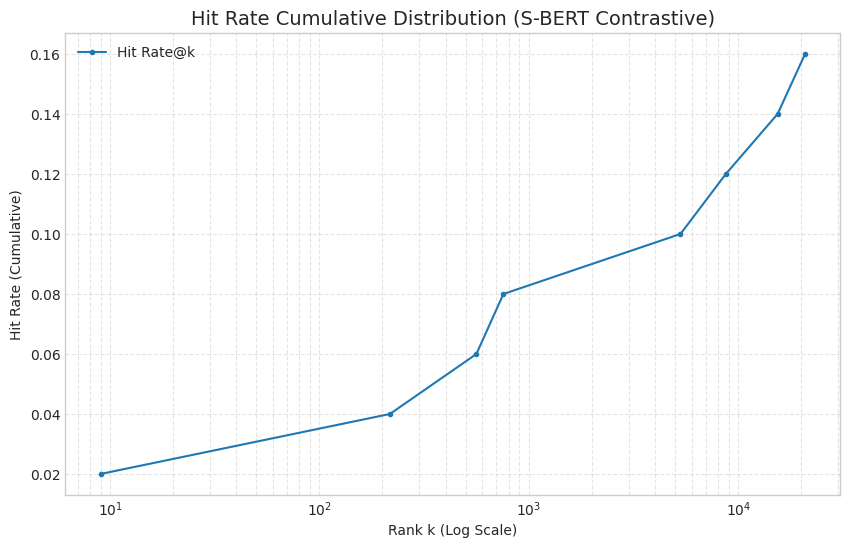

In [7]:
# ... (既存のコードの後ろに以下を追記) ...

print("\n" + "="*50)
print("--- Analysis: k for 90% Hit Rate ---")

# 1. ランクデータの準備
# (0 は「見つからなかった」を意味するので、無限大として扱う)
valid_ranks = [r for r in all_first_hit_ranks if r > 0]
sorted_ranks = sorted(valid_ranks)
total_queries = len(all_first_hit_ranks)

# 2. 90%を超えるkを探す
target_ratio = 0.9
found_k = None
current_hit_rate = 0.0

# ランクが小さい順に見ていき、累積割合が90%を超えた時点のランクを取得
for i, rank in enumerate(sorted_ranks):
    # (i+1) は「rank位以内に正解があったクエリ数」
    ratio = (i + 1) / total_queries
    
    if ratio >= target_ratio:
        found_k = rank
        current_hit_rate = ratio
        break

if found_k:
    print(f"✅ Hit Rate exceeds 90% at k = {found_k}")
    print(f"   (Actual Hit Rate: {current_hit_rate:.2%})")
    print(f"   つまり、検索結果を上位 {found_k} 件見れば、90%の確率で正解が含まれています。")
else:
    print(f"❌ Hit Rate did not reach 90% even with collected results.")
    max_hit_rate = len(valid_ranks) / total_queries
    print(f"   (Max Hit Rate found: {max_hit_rate:.2%})")

print("="*50)

# --- 3. Hit Rateの累積分布グラフ (CDF) を描画 ---
import matplotlib.pyplot as plt
import seaborn as sns

# データ作成: 全クエリ分のランク（見つからなかったものは除外）
x_values = sorted(valid_ranks)
y_values = [(i + 1) / total_queries for i in range(len(x_values))]

plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-whitegrid')

plt.plot(x_values, y_values, marker='.', linestyle='-', label='Hit Rate@k')

# 90%ラインを描画
if found_k:
    plt.axhline(y=0.9, color='r', linestyle='--', label='Target (90%)')
    plt.axvline(x=found_k, color='r', linestyle='--')
    plt.text(found_k, 0.91, f' k={found_k}', color='r', fontweight='bold')

plt.title('Hit Rate Cumulative Distribution (S-BERT Contrastive)', fontsize=14)
plt.xlabel('Rank k (Log Scale)')
plt.ylabel('Hit Rate (Cumulative)')
plt.xscale('log') # kは指数的に増えるため対数スケールが見やすい
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.show()